In [38]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import integrate

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML
import control
from misc_tools.print_latex import print_tex

# Inverted Pendulum Control

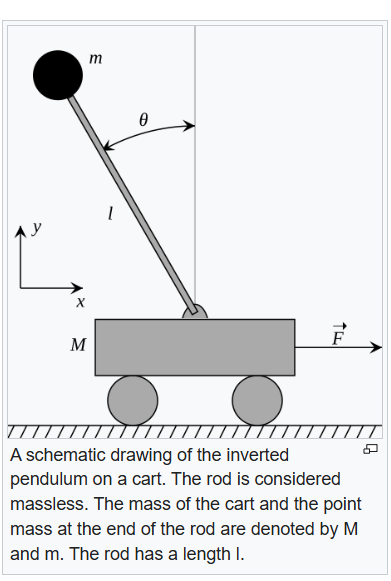

Derivation of equations via euler-lagrange equation:
 
[cart_pendulum_derivation.pdf](cart_pendulum_derivation.pdf)

https://en.wikipedia.org/wiki/Inverted_pendulum

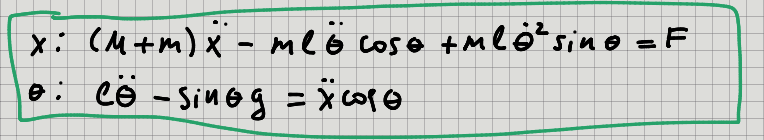

**Might have problems because of sign of $g$!!**

$$\begin{cases}
(M+m) \ddot x - m l \ddot \theta \cos \theta + m l {\dot\theta}^2 \sin \theta = F\\
l \ddot \theta - g\sin \theta = \ddot x \cos \theta
\end{cases}$$
can express form eq. 2, add damping/friction $\delta \dot x$  to non-conservative force $F$
$$ l \ddot \theta = \ddot x \cos \theta + g \sin \theta $$
$$(M+m) \ddot x - m \left(\ddot x \cos \theta + g\sin \theta\right) \cos \theta + m l {\dot\theta}^2 \sin \theta = F - \delta \dot x$$
$$(M+m) \ddot x - m \ddot x \cos^2 \theta  - m g\sin \theta\cos \theta+ m l {\dot\theta}^2 \sin \theta = F - \delta \dot x$$
$$(M+m-m\cos^2 \theta) \ddot x - m g\sin \theta\cos \theta+ m l {\dot\theta}^2 \sin \theta = F - \delta \dot x$$
$$(M+m(1 - \cos^2 \theta)) \ddot x - m g\sin \theta\cos \theta+ m l {\dot\theta}^2 \sin \theta = F - \delta \dot x$$
$$(M+m \sin^2 \theta) \ddot x - m g\sin \theta\cos \theta+ m l {\dot\theta}^2 \sin \theta = F - \delta \dot x$$
$$(M+m \sin^2 \theta) \ddot x = F - \delta \dot x + m g\sin \theta\cos \theta - m l {\dot\theta}^2 \sin \theta$$
$$\boxed{\ddot x = \frac{F - \delta \dot x + m g\sin \theta\cos \theta - m l {\dot\theta}^2 \sin \theta}{M+m \sin^2 \theta }}$$
$$D = M+m \sin^2 \theta $$

Cancel $\ddot x$ from eq 2
$$ l \ddot \theta = \ddot x \cos \theta + g\sin \theta \rightarrow$$

$$ l \ddot \theta= \frac{F - \delta \dot x + m g\sin \theta\cos \theta - m l {\dot\theta}^2 \sin \theta}{M+m \sin^2 \theta } \cos \theta + g\sin \theta$$
$$\boxed{\ddot \theta= \frac{\cos \theta}{l} \cdot \frac{F - \delta \dot x + m g\sin \theta\cos \theta - m l {\dot\theta}^2 \sin \theta}{M+m \sin^2 \theta }  + \frac{g}{l}\sin \theta}$$

## Rewrite as system of ODEs

State vector is
$$\vec x = 
\begin{bmatrix}
x_0 \\ x_1 \\ x_2 \\ x_3
\end{bmatrix}=

\begin{bmatrix}
x \\ \dot x \\ \theta \\ \dot \theta
\end{bmatrix}$$

$$\begin{cases}
\frac{\partial}{\partial t} x = \dot x  \\ 
\frac{\partial}{\partial t} \dot x =  \ddot x\\
\frac{\partial}{\partial t} \theta = \dot \theta \\
\frac{\partial}{\partial t} \dot \theta = \ddot \theta 
\end{cases} \longrightarrow
\begin{cases}
\frac{\partial}{\partial t} x_0 = x_1  \\ 
\frac{\partial}{\partial t} x_1 =  \ddot x_0 = \ddot x_0(x_0,x_1,x_2,x_3)\\
\frac{\partial}{\partial t} x_2 = x_3 \\
\frac{\partial}{\partial t} x_3 = \ddot \theta = \ddot \theta(x_0,x_1,x_2,x_3)
\end{cases}$$

$$



$$\ddot x = \frac{F - \delta \dot x + m g\sin \theta\cos \theta - m l {\dot\theta}^2 \sin \theta}{M+m \sin^2 \theta }=
\frac{F - \delta x_1 + m g\sin x_2\cos x_2 - m l {\dot\theta}^2 \sin x_2}{M+m \sin^2 x_2 }$$
$$\ddot \theta= \frac{\cos \theta}{l} \cdot \frac{F - \delta \dot x + m g\sin \theta\cos \theta - m l {\dot\theta}^2 \sin \theta}{M+m \sin^2 \theta }  + \frac{g}{l}\sin \theta=
\frac{\cos x_2}{l} \cdot \frac{F - \delta x_1 + m g \sin x_2 \cos x_2 - m l {x_3}^2 \sin x_2}{M+m \sin^2 x_2 }  + \frac{g}{l} \sin x_2$$

ODE system is
$$
\begin{cases}
\frac{\partial}{\partial t} x_0 = x_1  \\ 
\frac{\partial}{\partial t} x_1 =  \frac{F - \delta x_1 + m g\sin x_2\cos x_2 - m l x_3^2 \sin x_2}{M+m \sin^2 x_2 }\\
\frac{\partial}{\partial t} x_2 = x_3 \\
\frac{\partial}{\partial t} x_3 = \frac{\cos x_2}{l} \cdot \frac{F - \delta x_1 + m g \sin x_2 \cos x_2 - m l {x_3}^2 \sin x_2}{M+m \sin^2 x_2 }  + \frac{g}{l} \sin x_2
\end{cases}$$

**In practice i can reuse $\ddot x$ for $\ddot \theta$**
$$\boxed{\begin{cases}
\frac{\partial}{\partial t} x_0 = x_1  \\ 
\frac{\partial}{\partial t} x_1 =  \frac{F - \delta x_1 + m g\sin x_2\cos x_2 - m l x_3^2 \sin x_2}{M+m \sin^2 x_2 }\\
\frac{\partial}{\partial t} x_2 = x_3 \\
\frac{\partial}{\partial t} x_3 = \frac{1}{l} \left( \dot x_1 + \sin x_2\right)
\end{cases}}$$

## Animate

Took code from the book (Brunton, Kutz). Otherwise i would use Gym env.

In [75]:


def pendcart(x,t,m,M,L,g,d,uf):
    u = uf(x) # evaluate anonymous function at x
    Sx = np.sin(x[2])
    Cx = np.cos(x[2])
    dx = np.zeros(4)

    D = M+m*Sx**2
    dx[0] = x[1]
    dx[1] = 1/D*(u - d*x[1] + m*g*Sx*Cx - m*L*(x[3]**2)*Sx)
    dx[2] = x[3]
    dx[3] = 1/L*(dx[1]*Cx +g*Sx)
    # from book.
    D = m*L*L*(M+m*(1-Cx**2))
    dx[0] = x[1]
    dx[1] = (1/D)*(-m*(m*L*L)*g*Cx*Sx + (m*L*L)*(m*L*(x[3]**2)*Sx - d*x[1])) + (m*L*L)*(1/D)*u
    dx[2] = x[3]
    dx[3] = (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*(x[3]**2)*Sx - d*x[1])) - m*L*Cx*(1/D)*u;
    
    return dx

In [76]:

## Simulate closed-loop system
tspan = np.arange(0,10,0.001)
x0 = np.array([-1,0,np.pi+0.1,0]) # Initial condition

u = lambda x: 0           # Control law

m = 1
M = 5
L = 2
g = -10
d = 0.5
x = integrate.odeint(pendcart,x0,tspan,args=(m,M,L,g,d,u))

C:\Users\Hot Mexican\AppData\Local\Temp\ipykernel_9252\2469005898.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  p_cart.set_data(x_iter,0.1+H/2)


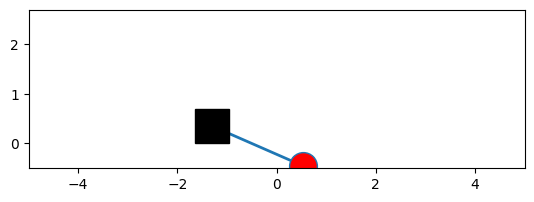

In [77]:


fig,ax = plt.subplots()
H = 0.5*np.sqrt(M/5);
p_pend, = plt.plot([],[],'o-',linewidth=2,ms=20,markerfacecolor='r');
p_cart, = plt.plot([],[],'ks',ms=25);
plt.gca().set_aspect('equal')

x_plot = x[::100,:]
t_plot = tspan[::100]

def init():
    ax.set_xlim(-5,5)
    ax.set_ylim(-0.5, 2.7)
    return x

def animate(iter):
    x_iter = x_plot[iter,0]
    th_iter = x_plot[iter,2]
    
    p_cart.set_data(x_iter,0.1+H/2)
    p_pend.set_data(x_iter+np.array([0,L*np.sin(th_iter)]),\
                    0.1+H/2+np.array([0,-L*np.cos(th_iter)]))
    return p_pend

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(t_plot),interval=50,blit=False,repeat=False);
HTML(anim.to_jshtml())


## Linearization

***
Lets remind us for example (chapter 2 on linearization and stability)

System $\dot{ \vec x }  = f(\vec x)$ can be written in matrix form as
$$\dot{ \vec x }  = f(\vec x) \rightarrow 
\frac{d}{dt}\begin{bmatrix}x_1\\ x_2\end{bmatrix}
=
\begin{bmatrix}x_2\\  -\sin x_1 - \delta x_2\end{bmatrix}$$

$$\boxed{J_{\vec f} (\vec x) = J_{\vec f}(x_1,x_2) = 
\begin{bmatrix}
\\
\frac{\partial f_1}{\partial x_1} &\frac{\partial f_1}{\partial x_2}\\
\\
\frac{\partial f_2}{\partial x_1} &\frac{\partial f_2}{\partial x_2}\\
\\
\end{bmatrix}=
\left[\frac{\partial f_i}{\partial x_j}\right]
}$$

$$\vec J_ f(x_1,x_2) = 
\begin{bmatrix}
\frac{\partial x_2}{\partial x_1} &\frac{\partial x_2}{\partial x_2}\\
\frac{\partial (-\sin x_1 - \delta x_2)}{\partial x_1} &\frac{\partial (\sin x_1 - \delta x_2)}{\partial x_2}
\end{bmatrix}=
\begin{bmatrix}
0 & 1\\
-\cos x_1 & -\delta\\
\end{bmatrix}
$$
***

In our case:
$$\begin{cases}
\frac{\partial}{\partial t} x_0 = x_1  \\ 
\frac{\partial}{\partial t} x_1 =  \frac{F - \delta x_1 + m g\sin x_2\cos x_2 - m l x_3^2 \sin x_2}{M+m \sin^2 x_2 }\\
\frac{\partial}{\partial t} x_2 = x_3 \\
\frac{\partial}{\partial t} x_3 = \frac{1}{l} \left( \dot x_1 + \sin x_2\right)
\end{cases}$$
with fixed points at 
$$\begin{cases}
x= x_0 \in  \R \\
\dot x = x_1 = 0 \\
\theta = x_2 =\{0, \pi\} \\
\dot \theta = x_3 = 0 \\
\end{cases}$$


By rows:

$$\frac{\partial f_0}{\partial \vec x} = 
\begin{bmatrix}
0 & 1 & 0 & 0
\end{bmatrix}$$

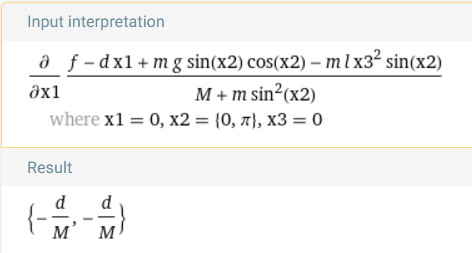
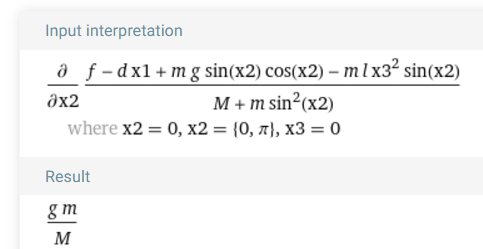

$$\frac{\partial f_1}{\partial \vec x} = 
\begin{bmatrix}
0 & -\frac{d}{M} & \frac{g m}{M} & 0
\end{bmatrix}$$

$$\frac{\partial f_2}{\partial \vec x} = 
\begin{bmatrix}
0 & 0 & 0 & 1
\end{bmatrix}$$

***
Maybe since $$f_3 = \frac{1}{l} \left( \dot x_1 + \sin x_2\right)$$
and
$$\dot x_1 = f_1(x_0,x_1,x_2,x_3)$$
then
$$\frac{\partial f_2}{\partial x_i} =  \frac{1}{l} \left(\frac{\partial f_1}{\partial x_i}+ \sin x_2\right)$$
Is it possible? Since its is a linear combination (regarding when to insert boundary conditions). Likely not, we dont get pole switching

$$\frac{\partial f_3}{\partial \vec x} = 
\begin{bmatrix}
0 & -\frac{d}{LM} & \frac{1}{L}(\frac{g m}{M} + \cos x_2)& 0
\end{bmatrix}$$
***
Anyway. I dont want to calculate this xd. switch $s = \pm 1$ for states

$$\frac{\partial f_3}{\partial \vec x} = 
\begin{bmatrix}
0 & -s\frac{d}{LM} & -s\frac{(m+M)g }{M L}& 0
\end{bmatrix}$$

Linearization matrix is the following:

$$A = \begin{bmatrix}
0 & 1 & 0 & 0\\
0 & -\frac{d}{M} & \frac{g m}{M} & 0\\
0 & 0 & 0 & 1\\
0 & -s\frac{d}{LM} & -s\frac{(m+M)g }{M L}& 0
\end{bmatrix}$$

Lets test stability and controllability

In [78]:

for ss in [-1,1]:
    A = np.array([
        [0,1,0,0],
        [0,-d/M, g*m/M,0],
        [0,0,0,1],
        [0, -ss*d/L/M, -ss*(m+M)*g/L/M, 0]
    ])
    eigs = np.linalg.eigvals(A).real
    B = np.array([[0, 1/M, 0, ss/L/M]]).T
    C = control.ctrb(A,B)
    print_tex(r"\text{(state: "+ str(ss) +") } ; A = ", A, r"\ ; \vec \lambda= ", eigs, r"\text{; rank(C)} = ", np.linalg.matrix_rank(C))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [80]:

eigs_new = np.array([-0.5, -1, -1.5, -2])
K = control.place(A, B, eigs_new)

A_cl = A - B @ K
eigs_cl = np.linalg.eigvals(A_cl)
print_tex("K = ", K)
print_tex("A_{CL} = ", A_cl, r"\ ; \vec \lambda= ", eigs_cl)

wr = np.array([1,0,np.pi,0])      # Reference position
u = lambda x: (-K@(x-wr))[0]         # Control law

pendcart(x0,tspan, m,M,L,g,d,u)

x = integrate.odeint(pendcart,x0,tspan,args=(m,M,L,g,d,u))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

C:\Users\Hot Mexican\AppData\Local\Temp\ipykernel_9252\2717996633.py:19: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  p_cart.set_data(x_iter,0.1+H/2)


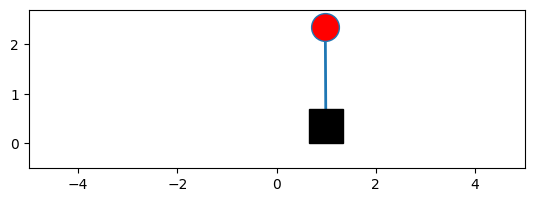

In [81]:

fig,ax = plt.subplots()
H = 0.5*np.sqrt(M/5);
p_pend, = plt.plot([],[],'o-',linewidth=2,ms=20,markerfacecolor='r');
p_cart, = plt.plot([],[],'ks',ms=25);
plt.gca().set_aspect('equal')

x_plot = x[::100,:]
t_plot = tspan[::100]

def init():
    ax.set_xlim(-5,5)
    ax.set_ylim(-0.5, 2.7)
    return x

def animate(iter):
    x_iter = x_plot[iter,0]
    th_iter = x_plot[iter,2]
    
    p_cart.set_data(x_iter,0.1+H/2)
    p_pend.set_data(x_iter+np.array([0,L*np.sin(th_iter)]),\
                    0.1+H/2+np.array([0,-L*np.cos(th_iter)]))
    return p_pend

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(t_plot),interval=50,blit=False,repeat=False);
HTML(anim.to_jshtml())

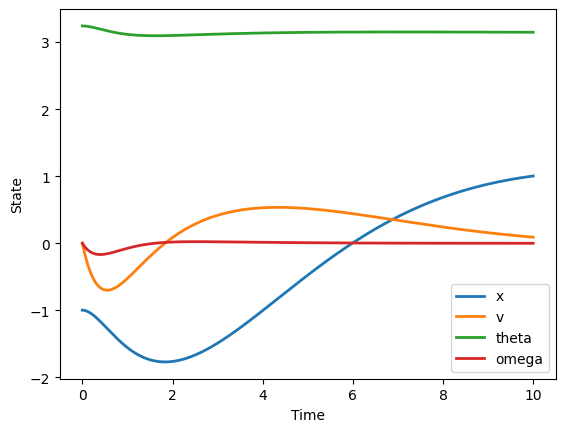

In [82]:
plot_labels = ('x','v','theta','omega')
[plt.plot(tspan,x[:,j],linewidth=2,label=plot_labels[j]) for j in range(4)]
plt.xlabel('Time')
plt.ylabel('State')

plt.legend()
plt.show()